In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.kernel_approximation import Nystroem

In [ ]:
file_path = '/content/data.csv'
df = pd.read_csv(file_path)

In [ ]:
df.tail()
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [ ]:
# Handling Outliers using IQR Method
def remove_outliers_iqr(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1

    # Define acceptable range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    df_filtered = df[~((df[columns] < lower_bound) | (df[columns] > upper_bound)).any(axis=1)]
    return df_filtered


In [ ]:
# Select key numerical features for outlier removal
selected_features = [" ROA(C) before interest and depreciation before interest",
                     " Net Income to Total Assets",
                     " Total debt/Total net worth",
                     " Cash/Total Assets",
                     " Operating Gross Margin"]
df_cleaned = remove_outliers_iqr(df, selected_features)

In [ ]:
# === Feature Selection using Variance Threshold ===
X = df_cleaned.iloc[:, 1:]  # Exclude target variable
y = df_cleaned["Bankrupt?"]

In [ ]:
# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()]

df_reduced = pd.DataFrame(X_selected, columns=selected_features)
df_reduced.insert(0, "Bankrupt?", y.values)  # Reinsert target variable

In [ ]:
sample_fraction = 0.5  # Use only 50% of data
if len(df_reduced) > 5000:
    df_reduced = df_reduced.sample(frac=sample_fraction, random_state=42)

In [ ]:
# Display dataset shape after feature selection
print("Original Features:", X.shape[1])
print("Selected Features:", df_reduced.shape[1] - 1)

Original Features: 95
Selected Features: 25


<ipython-input-92-b3920a7a683c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_reduced["Bankrupt?"], palette=["#1f77b4", "#ff7f0e"])


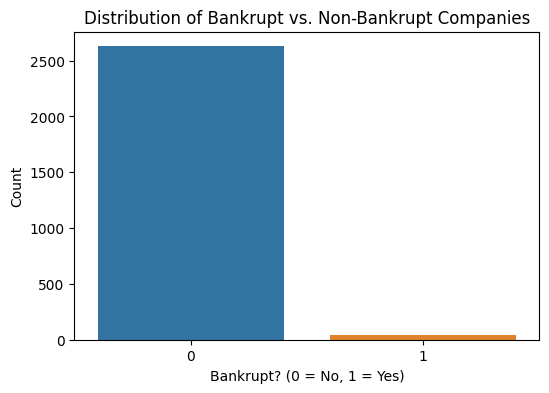

In [ ]:
# Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df_reduced["Bankrupt?"], palette=["#1f77b4", "#ff7f0e"])
plt.title("Distribution of Bankrupt vs. Non-Bankrupt Companies")
plt.xlabel("Bankrupt? (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [ ]:
#Save the processed dataset
processed_file_path = "/content/cleaned_bankruptcy_data.csv"
df_reduced.to_csv(processed_file_path, index=False)
print(f"Processed dataset saved at: {processed_file_path}")

Processed dataset saved at: /content/cleaned_bankruptcy_data.csv


In [ ]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(df_reduced.iloc[:, 1:], df_reduced["Bankrupt?"], test_size=0.2, random_state=42, stratify=df_reduced["Bankrupt?"])


In [ ]:
# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

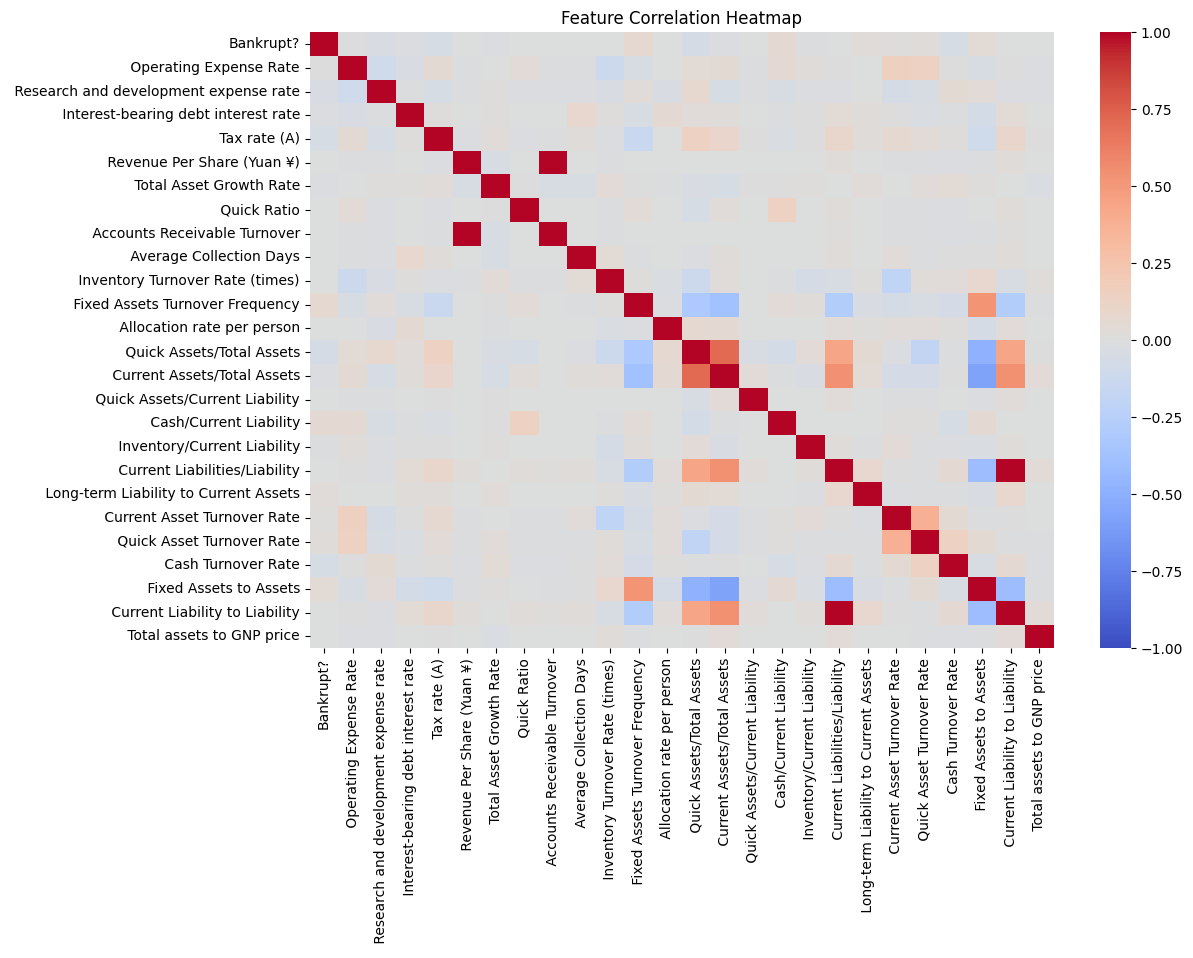

In [ ]:
# Feature Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_reduced.corr(), cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Standardizing the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

In [ ]:
# Gaussian Process for faster training
feature_map_nystroem = Nystroem(kernel="rbf", random_state=42, n_components=100)
X_train_nystroem = feature_map_nystroem.fit_transform(X_train_resampled)
X_test_nystroem = feature_map_nystroem.transform(X_test)

In [ ]:
# Define models
models = {
    "Gaussian Process": GaussianProcessClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42)
}

In [ ]:
# Train and evaluate models
for name, model in models.items():
    print(f"\nTraining {name}...")
    try:
        if name == "Gaussian Process":
            print("Applying Nystroem feature transformation for Gaussian Process...")
            model.fit(X_train_nystroem, y_train_resampled)
            y_pred = model.predict(X_test_nystroem)
        else:
            model.fit(X_train_resampled, y_train_resampled)
            y_pred = model.predict(X_test)

        print(f"{name} training completed.")

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {accuracy:.4f}")
        print("Classification Report:\n", classification_report(y_test, y_pred))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    except Exception as e:
        print(f"Error training {name}: {e}")


Training Gaussian Process...
Applying Nystroem feature transformation for Gaussian Process...
Gaussian Process training completed.
Gaussian Process Accuracy: 0.8879
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       526
           1       0.04      0.22      0.06         9

    accuracy                           0.89       535
   macro avg       0.51      0.56      0.50       535
weighted avg       0.97      0.89      0.93       535

Confusion Matrix:
 [[473  53]
 [  7   2]]

Training Random Forest...
Random Forest training completed.
Random Forest Accuracy: 0.9776
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       526
           1       0.00      0.00      0.00         9

    accuracy                           0.98       535
   macro avg       0.49      0.50      0.49       535
weighted avg       0.97      0.98      0.97       535